In [1]:
import py_wgpu_fdm as fdm
import numpy as np
import math

Simulation settings; these are immutable and should be kept consistent across all simluations:
+ `node_count` defines the amount of nodes
+ `chunk_size` defines the size out the output buffer that are kept in GPU memory before being pushed to the CPU
+ `oversampling_factor` defines the how many steps are calculated per saved output. This is done to increase numerical stability.

Thus the total number of calculations is `node_count * chunk_size * oversampling_factor`


In [2]:
node_count = 2048
chunk_size = 1024
oversampling_factor = 128

sampling_rate = 44100

Next we define all necessary parameters for the respective simulation.

In [3]:
# Simluation parameters
L = 1.945                            # Length (m)
dx = L / (node_count - 1)            # Spatial delta
T = 1.0                              # Total duration (s)
dt = 1/(sampling_rate * oversampling_factor) # Time delta (s)

In [4]:
A = 1.31e-6                          # Cross-sectional area (m^2)
rho = 44290                          # Density (kg/m^3)
F_T = 1328                           # Tensile force (N)
E = 2.02e11                          # Young's Modulus (Pa)
I = 1.78e-14                         # Moment of Inertia of Area (m^4)
G = 1.00e10                          # Shear Modulus (Pa)
kappa = 0.95                         # Shear correction factor (1)

GA = G * kappa * A
EI = E * I
rhoI = rho * I
m = rho * A

as well as the intial conditions. Here we set the initial velocity to a gaussian bell curve with a choice of sigma = 0.02

In [23]:
gaussian_disp = lambda n, i, max_val: float(0.0 if i == 0 or i == n - 1 else max_val * \
    np.exp(-((i - (n - 1) / 2) ** 2) / (2 * (n * 0.02) ** 2)))

#max_displacement = 0.20
max_displacement = 0.0

ws = [ gaussian_disp(node_count, i, max_displacement) for i in range(node_count) ]
phis = [float(f) for f in np.gradient(ws) ]
nodes = list()

for i in range(node_count):
    nodes.append([ [0.0, 0.0, 0.0, 0.0 ],[ ws[i], 0.0, ws[i], 0.0 ]])

We can now create a new Simulation instance and set up its parameters, matching them to the appropriate generic paramter names (j, k, etc.) defined in the shader.
This creates a simulation instance that lives in memory allocated by rust and handles all GPU interaction.

In [7]:
# Initialize simulation
sim = fdm.Simulation(nodes, chunk_size, oversampling_factor)

# Set parameters
sim.set_dx(dx)
sim.set_dt(dt)
sim.set_j(GA)
sim.set_k(EI)
sim.set_m(m)
sim.set_l(rhoI)
sim.set_n(F_T)
sim.set_o(0.999999999)        # dampening factor
sim.set_p(0.0)                # theta


Given a chunk size and an effective time delta (including the oversampling factor), we can calculate the amount of required compute invocations:

In [8]:
invocations = math.ceil(44100 * T / chunk_size) # minimum amount of invocations required

print(f'Calling compute() {invocations} times.')

Calling compute() 44 times.


Finally we run the simulation `invocations`-times and append generated output to our list. 
The output on the rust side includes both w and phi, so we should also extract the field we're interested in.

In [9]:
%%time
result = list()

for i in range(invocations):
    result += sim.compute()

displacements = [ r[0] for r in result ]

CPU times: user 41.4 s, sys: 3.28 s, total: 44.7 s
Wall time: 2min 8s


We can plot the output. Though this is a somewhat meaningless graph for high frequences or longer durations, it can be useful for identifying simulation runs with unstable parameter choices.

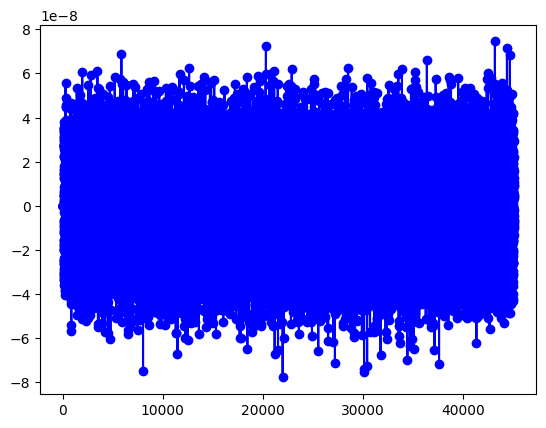

In [10]:
import matplotlib.pyplot as plt

plt.plot(displacements, marker='o', linestyle='-', color='b')
plt.show()

The FFT of the signal is more more interesting:

In [11]:
def plot_ffts(lists, max_range):
    plt.figure(figsize=(10, 6))
    plt.title('FFT of the Signal')    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    for displacements in lists:
        fft_result = np.fft.fft(displacements)
        fft_magnitude = np.abs(fft_result)[:len(fft_result)//2]  # Take only the positive frequencies
        freqs = np.fft.fftfreq(len(result), 1 / sampling_rate)[:len(fft_result)//2]
        plt.plot(freqs[:max_range], fft_magnitude[:max_range])

        

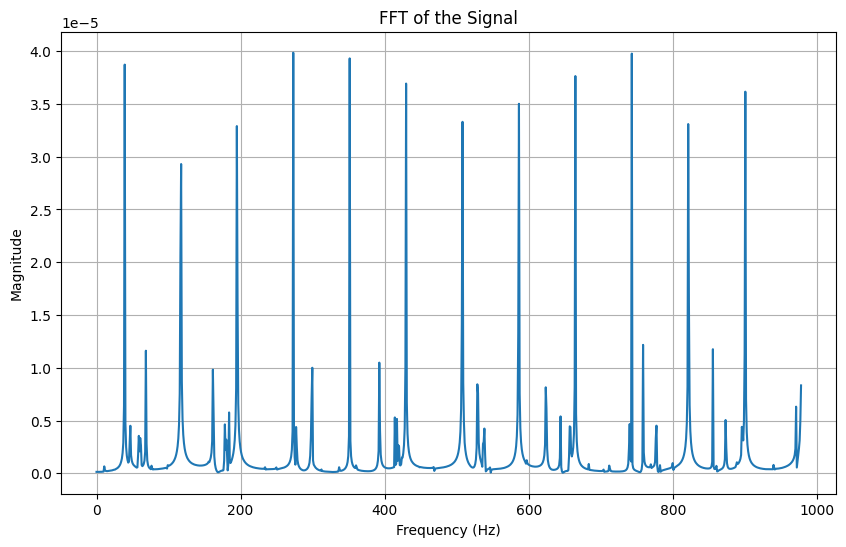

In [12]:
plot_ffts([displacements], 1000)

We can run the same simulation again, using a modified stiffness matrix, saving the output.

In [13]:
# Initialize simulation
sim = fdm.Simulation(nodes, chunk_size, oversampling_factor)

# Set parameters
sim.set_dx(dx)
sim.set_dt(dt)
sim.set_j(GA)
sim.set_k(EI)
sim.set_m(m)
sim.set_l(rhoI)
sim.set_n(F_T)
sim.set_o(0.999999999)
sim.set_p(1/4)

In [14]:
%%time

theta_result = list()

for i in range(invocations):
    theta_result += sim.compute()

theta_displacements = [ r[0] for r in theta_result ]

CPU times: user 41.6 s, sys: 3.16 s, total: 44.7 s
Wall time: 2min 9s


We run the simulation one more time, setting theta and GA to 0.
This effectively removes any stiffness from the system, reducing it to the 1-D wave equation.

In [15]:
# Initialize simulation
sim = fdm.Simulation(nodes, chunk_size, oversampling_factor)

# Set parameters
sim.set_dx(dx)
sim.set_dt(dt)
sim.set_j(0)
sim.set_k(EI)
sim.set_m(m)
sim.set_l(rhoI)
sim.set_n(F_T)
sim.set_o(0.999999999)
sim.set_p(0)

In [16]:
%%time

wave_result = list()

for i in range(invocations):
    wave_result += sim.compute()

wave_displacements = [ r[0] for r in wave_result ]

CPU times: user 41.2 s, sys: 3.23 s, total: 44.4 s
Wall time: 2min 7s


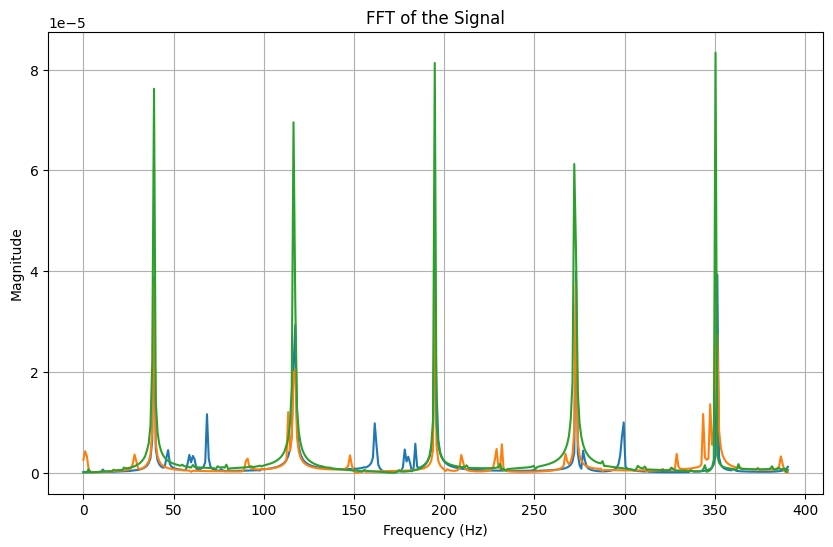

In [20]:
plot_ffts([displacements, theta_displacements, wave_displacements], 400)

In [22]:
import sounddevice as sd

def normalize_audio(audio):
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        return audio / (8*max_val)
    else:
        return audio

# Normalize audio
audio_normalized = normalize_audio(displacements)

# Play normalized audio
sd.play(audio_normalized, 44100)
sd.wait()


In [19]:
max(displacements)

7.448897321182812e-08